# Frictionless Cars

This notebook is meant to show a simple artificial example of working with Frcitionless Framework. We will load data from different source, clean, and transform it to get some insight regarding electrical vehicles. 

> **Our hypothesis is trivial. We think that domestic product of a country might correlate with a share of electrical cars in this country. We will use open data and Frictionless Framework to test this idea.**

## Installation

First of all, we need to install Frictionless and a few plugins we need for this tutorial:

In [1]:
! pip install frictionless[html,pandas]

In [2]:
! frictionless --version

4.29.0


## Getting Started

To simplify the notebook visually we import all the functions and classes we need beforehand and re-use them in the codeblocks in the following sections:

In [3]:
from frictionless import Package, Resource, transform, steps
from frictionless.plugins.html import HtmlDialect

## Electrical Vehicles

> https://en.wikipedia.org/wiki/Electric_car_use_by_country

We will use an HTML page published by Wikipedia to get the data about electrical car shares in some countries. We're using the `HtmlDialect` to provide a CSS selector of the table we need:

In [4]:
raw_cars = Resource(
    "https://en.wikipedia.org/wiki/Electric_car_use_by_country",
    name="cars",
    format="html",
    dialect=HtmlDialect(selector=".wikitable.sortable"),
)
print(raw_cars.to_view())

+----------------------+--------------------------------------------------+---------------------+---------------------+-----------------------------+
| Country or Region    | PEV stock/ cumulative sales (2021)[i]            | Annual sales (2021) | Market share (2021) | % of cars in use (2021)[ii] |
+======================+==================================================+=====================+=====================+=============================+
| 'China[iii]'         | '7.84\xa0million[12]'                            | '3,334,000[67]'     | '15%[68]'           | '2.6%[12]'                  |
+----------------------+--------------------------------------------------+---------------------+---------------------+-----------------------------+
| 'Europe[iv]'         | '≈5.67\xa0million\n[13][14][15][31][69][70][71]' | '2,332,798[13][15]' | '19%[13]'           | '1.1%[72] (2020)'           |
+----------------------+--------------------------------------------------+---------------------+---

We got the data and it looks just terrible and useless. It's a common problem of parsing HTML documents created for humans. We will use the `transform` function to clean this table and extract fields that we need:

In [5]:
# Change year based on above data header 'Annual sales (2021)'
year = 2021

cars = transform(
    raw_cars,
    steps=[
        steps.row_slice(stop=12),
        steps.cell_convert(field_name="Country or Region", function=lambda v: v.split("[")[0]),
        steps.field_add(
            name="Share",
            type="number",
            function=lambda r: r[f"% of cars\nin use ({year})[ii]"].split("%")[0],
        ),
        steps.field_filter(names=["Country or Region", "Share"]),
    ],
)
# cars.schema.get_field("Country or Region").name = "Country"
print(cars.to_view())

+-------------------+-----------------+
| Country or Region | Share           |
+===================+=================+
| 'China'           |  Decimal('2.6') |
+-------------------+-----------------+
| 'Europe'          |  Decimal('1.1') |
+-------------------+-----------------+
| 'United States'   |  Decimal('0.7') |
+-------------------+-----------------+
| 'Germany'         |  Decimal('2.5') |
+-------------------+-----------------+
| 'California'      | Decimal('2.27') |
+-------------------+-----------------+
...



## Domestic Product

> https://github.com/datasets/gdp

Our next step is to gather some economical metric to compare the level of countries' prosperity. Usually, GDP is used for this task. Let's load a data package containing this information:


In [6]:
raw_product = Package(
  "https://raw.githubusercontent.com/datasets/gdp/master/datapackage.json"
).get_resource("gdp")

print(raw_product.to_view())

+--------------+--------------+------+-----------------------------+
| Country Name | Country Code | Year | Value                       |
+==============+==============+======+=============================+
| 'Arab World' | 'ARB'        | 1968 | Decimal('25760683041.0857') |
+--------------+--------------+------+-----------------------------+
| 'Arab World' | 'ARB'        | 1969 | Decimal('28434203615.4829') |
+--------------+--------------+------+-----------------------------+
| 'Arab World' | 'ARB'        | 1970 | Decimal('31385499664.0672') |
+--------------+--------------+------+-----------------------------+
| 'Arab World' | 'ARB'        | 1971 | Decimal('36426909888.3928') |
+--------------+--------------+------+-----------------------------+
| 'Arab World' | 'ARB'        | 1972 | Decimal('43316056615.4562') |
+--------------+--------------+------+-----------------------------+
...



As we can see it contains per year information and we only want the latest data. Let's use the `transform` function to fix it: 

In [7]:
product = transform(
    raw_product,
    steps=[
        steps.row_filter(function=lambda r: r["Year"] == "2016"),
        steps.field_add(name="Country or Region", position=1, function=lambda r: r["Country Name"]),
        steps.field_filter(names=["Country or Region", "Value"]),
    ],
)

print(product.to_view())
print(product)
print(cars)

+----------------------------------+-----------------------------+
| Country or Region                | Value                       |
+==================================+=============================+
| 'Arab World'                     | Decimal('2504702625568.63') |
+----------------------------------+-----------------------------+
| 'Caribbean small states'         |  Decimal('66707362091.378') |
+----------------------------------+-----------------------------+
| 'Central Europe and the Baltics' | Decimal('1312157690492.89') |
+----------------------------------+-----------------------------+
| 'Early-demographic dividend'     | Decimal('10401989026722.8') |
+----------------------------------+-----------------------------+
| 'East Asia & Pacific'            | Decimal('22480427869996.2') |
+----------------------------------+-----------------------------+
...

{'name': 'gdp', 'schema': {'fields': [{'name': 'Country or Region'}, {'description': 'GDP in current USD', 'name': 'Value', 

## Is There a Correlation?

Now we have enough data to test our hypothesis. We just need to join two tables we prepared in the steps above:

In [8]:
correlation = transform(
    cars.to_copy(name="correlation"),
    steps=[
        steps.table_join(resource=product, field_name="Country or Region"),
        steps.row_sort(field_names=['Value'], reverse=True),
    ],
)
print(correlation.to_view())

+-------------------+-----------------+-----------------------------+
| Country or Region | Share           | Value                       |
+===================+=================+=============================+
| 'Sweden'          |    Decimal('4') | Decimal('514459972806.171') |
+-------------------+-----------------+-----------------------------+
| 'United Kingdom'  | Decimal('1.38') | Decimal('2647898654635.24') |
+-------------------+-----------------+-----------------------------+
| 'United States'   |  Decimal('0.7') |   Decimal('18624475000000') |
+-------------------+-----------------+-----------------------------+



In [9]:
cars.to_view()

"+-------------------+-----------------+\n| Country or Region | Share           |\n+===================+=================+\n| 'China'           |  Decimal('2.6') |\n+-------------------+-----------------+\n| 'Europe'          |  Decimal('1.1') |\n+-------------------+-----------------+\n| 'United States'   |  Decimal('0.7') |\n+-------------------+-----------------+\n| 'Germany'         |  Decimal('2.5') |\n+-------------------+-----------------+\n| 'California'      | Decimal('2.27') |\n+-------------------+-----------------+\n...\n"

Let's export the `correlation` resource as a Pandas dataframe:

In [10]:
df = correlation.to_pandas()
print(df)

  Country or Region  Share         Value
0            Sweden   4.00  5.144600e+11
1    United Kingdom   1.38  2.647899e+12
2     United States   0.70  1.862448e+13


Having a Pandas dataframe we can use the plot's functions to visualize our data:

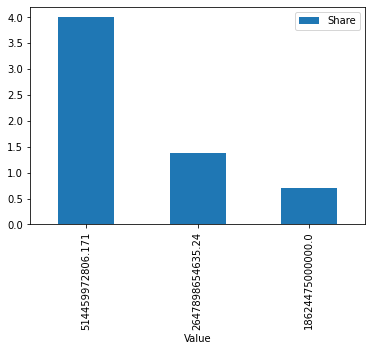

In [11]:
df.plot.bar(x="Value", y="Share")

> **OK. It seems we were wrong. There is no correlation. We probably should have used GDP per capita instead of just GDP. Please feel free to fork this notebook and continue our research =)**

## Exporting the Data Package

As a last step of our journey let's export the data package we created into a SQL database:

```python
package = Package(resources=[cars, product, correlation])
package.to_sql('<database-url>')
```

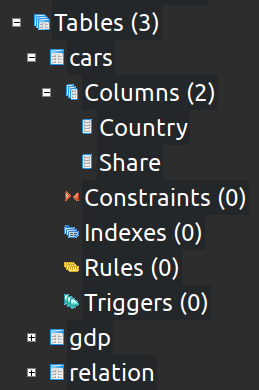